# 1. Imports

In [68]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

from collections import Counter
from string import punctuation
import gdown
import os
import warnings
import re

In [69]:
%matplotlib inline
plt.style.use('fivethirtyeight')
sns.set_style('whitegrid')
warnings.filterwarnings('ignore')

In [70]:
print(f"PyTorch Version: {torch.__version__}")
print(f"NumPy Version: {np.__version__}")
print(f"Pandas Version: {pd.__version__}")
print(f"CUDA Available: {torch.cuda.is_available()}")

if torch.cuda.is_available():
    print(f"CUDA Version: {torch.version.cuda}")
    print(f"GPU Device: {torch.cuda.get_device_name(0)}")

# Set random seeds for reproducible results
torch.manual_seed(42)
np.random.seed(42)

PyTorch Version: 2.9.0+cu126
NumPy Version: 2.0.2
Pandas Version: 2.2.2
CUDA Available: True
CUDA Version: 12.6
GPU Device: Tesla T4


In [71]:
DATASET_URL = 'https://drive.google.com/uc?id=1c7crkkuc32cgjSb2z9uIzqv9aQy9u9NC'
DATASET_FILENAME = 'IMDB Dataset.csv'

print("=== DATASET ACQUISITION ===")
print(f"Downloading IMDb dataset from secure source...")
print(f"Target file: {DATASET_FILENAME}")
print("=" * 60)

gdown.download(DATASET_URL, DATASET_FILENAME, quiet=False)

if os.path.exists(DATASET_FILENAME):
    file_size = os.path.getsize(DATASET_FILENAME) / (1024 * 1024)  # Size in MB
    print(f"Dataset successfully downloaded")
    print(f"File size: {file_size:.2f} MB")
else:
    print("Dataset download failed")
    raise FileNotFoundError(f"Could not download {DATASET_FILENAME}")

=== DATASET ACQUISITION ===
Target file: IMDB Dataset.csv


Downloading...
From: https://drive.google.com/uc?id=1c7crkkuc32cgjSb2z9uIzqv9aQy9u9NC
To: /content/IMDB Dataset.csv
100%|██████████| 66.2M/66.2M [00:01<00:00, 53.6MB/s]


Dataset successfully downloaded
File size: 63.14 MB


# 2. Data Exploration

In [72]:
df = pd.read_csv(DATASET_FILENAME)

print("DATASET STRUCTURE")
print(df.head())

print(f"\nDataset Dimensions : {df.shape}")

missing_values = df.isnull().sum()
print(f"\nMissing Values per Column:\n{missing_values}")

DATASET STRUCTURE
                                              review sentiment
0  One of the other reviewers has mentioned that ...  positive
1  A wonderful little production. <br /><br />The...  positive
2  I thought this was a wonderful way to spend ti...  positive
3  Basically there's a family where a little boy ...  negative
4  Petter Mattei's "Love in the Time of Money" is...  positive

Dataset Dimensions : (50000, 2)

Missing Values per Column:
review       0
sentiment    0
dtype: int64


In [73]:
sentiment_counts = df['sentiment'].value_counts()
print(f"\nClass Distribution:\n{sentiment_counts}")
print(f"Class Balance Ratio: {sentiment_counts.min() / sentiment_counts.max():.4f}")

df['review_length'] = df['review'].apply(len) # new column created with review length
print("\nReview Length Statistics:")
print(df['review_length'].describe())


Class Distribution:
sentiment
positive    25000
negative    25000
Name: count, dtype: int64
Class Balance Ratio: 1.0000

Review Length Statistics:
count    50000.000000
mean      1309.431020
std        989.728014
min         32.000000
25%        699.000000
50%        970.000000
75%       1590.250000
max      13704.000000
Name: review_length, dtype: float64


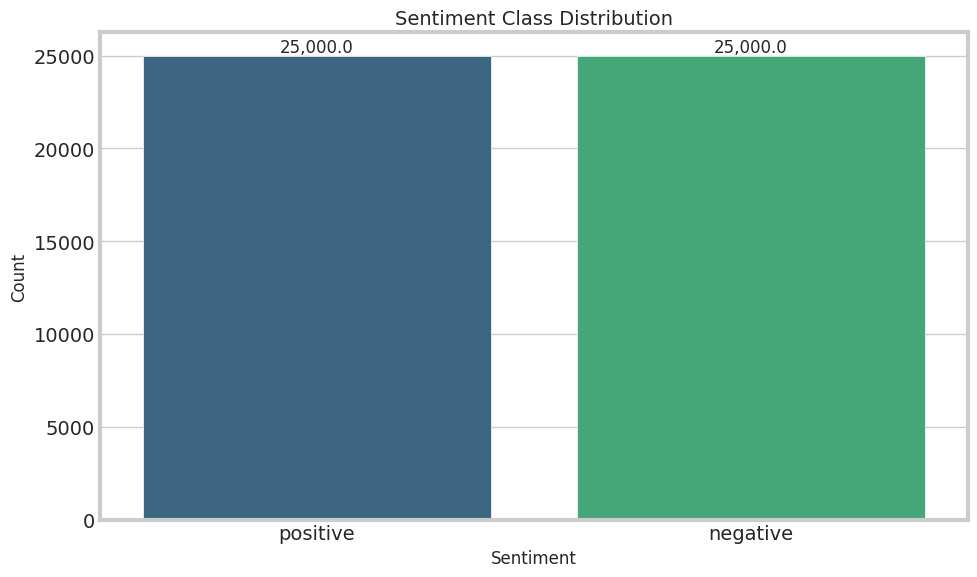

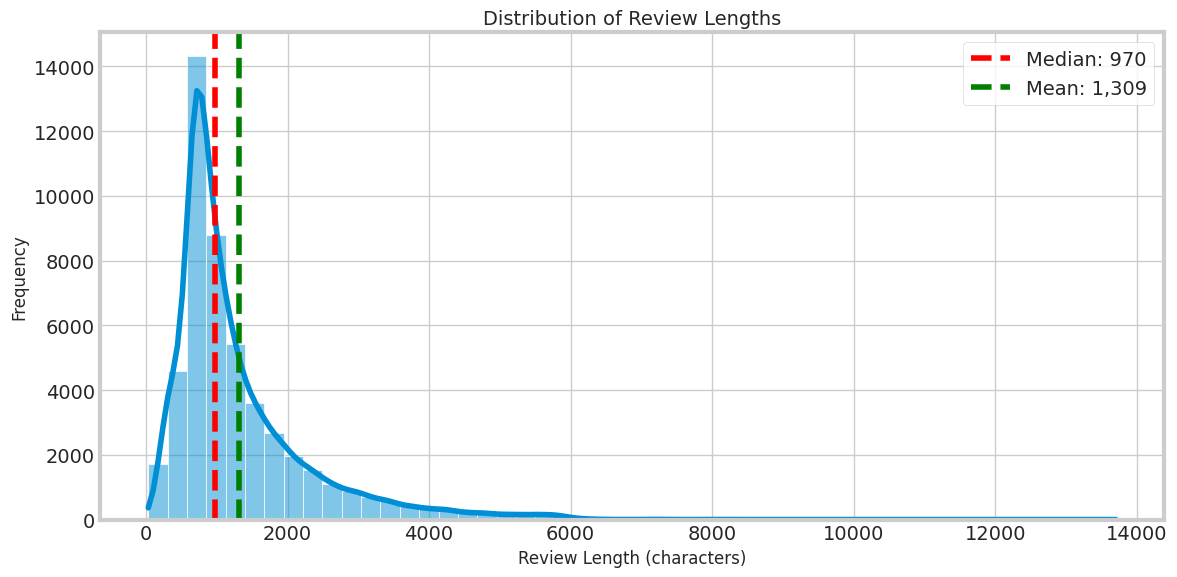

In [74]:
# Visualize class distribution
plt.figure(figsize=(10, 6))
ax = sns.countplot(x='sentiment', data=df, palette='viridis')
plt.title('Sentiment Class Distribution', fontsize=14)
plt.xlabel('Sentiment', fontsize=12)
plt.ylabel('Count', fontsize=12)

# Add count labels on bars
for p in ax.patches:
    ax.annotate(f'{p.get_height():,}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='bottom', fontsize=12)

plt.tight_layout()
plt.show()

# Visualize review length distribution
plt.figure(figsize=(12, 6))
sns.histplot(data=df, x='review_length', bins=50, kde=True)
plt.title('Distribution of Review Lengths', fontsize=14)
plt.xlabel('Review Length (characters)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.axvline(x=df['review_length'].median(), color='red', linestyle='--', label=f'Median: {df["review_length"].median():,.0f}')
plt.axvline(x=df['review_length'].mean(), color='green', linestyle='--', label=f'Mean: {df["review_length"].mean():,.0f}')
plt.legend()
plt.tight_layout()
plt.show()

In [75]:
# Sample review inspection
print("SAMPLE REVIEW ANALYSIS")
sample_positive = df[df['sentiment'] == 'positive'].iloc[0]
sample_negative = df[df['sentiment'] == 'negative'].iloc[0]

print("\nSample Positive Review:")
print(sample_positive['review'][:500] + "...")  # Truncate for display clarity
print(f"Length: {len(sample_positive['review'])} characters")

print("\nSample Negative Review:")
print(sample_negative['review'][:500] + "...")  # Truncate for display clarity
print(f"Length: {len(sample_negative['review'])} characters")

SAMPLE REVIEW ANALYSIS

Sample Positive Review:
One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word.<br /><br />It is called OZ...
Length: 1761 characters

Sample Negative Review:
Basically there's a family where a little boy (Jake) thinks there's a zombie in his closet & his parents are fighting all the time.<br /><br />This movie is slower than a soap opera... and suddenly, Jake decides to become Rambo and kill the zombie.<br /><br />OK, first of all when you're going to make a film you must Decide if its a thriller or a drama! As a drama the movie is watchable. Parents 

# 3. Preprocessing

### 3.1 Normalization (lower case)

In [76]:
print('Applying test normalization...')
df['review_normalized'] = df['review'].apply(lambda x : x.lower())
print("Done!")

Applying test normalization...
Done!


In [77]:
print("Sample normalized")
original = df['review'].iloc[0][:100]
normalized = df['review_normalized'].iloc[0][:100]
print(f"Original: {original}")
print(f"Normalized: {normalized}")

Sample normalized
Original: One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. The
Normalized: one of the other reviewers has mentioned that after watching just 1 oz episode you'll be hooked. the


### 3.2 Punctuation removal

In [78]:
print("\nPunctuation characters to remove:")
print(punctuation)

print("\nApplying punctuation removal...")
df['clean_text'] = df['review_normalized'].apply(lambda x: ''.join([c for c in x if c not in punctuation]))
print("Done!")

print("\nPunctuation Removal Example:")
normalized_with_punct = df['review_normalized'].iloc[0][:100]
cleaned_text = df['clean_text'].iloc[0][:100]
print(f"Before: {normalized_with_punct}...")
print(f"After: {cleaned_text}...")


Punctuation characters to remove:
!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~

Applying punctuation removal...
Done!

Punctuation Removal Example:
Before: one of the other reviewers has mentioned that after watching just 1 oz episode you'll be hooked. the...
After: one of the other reviewers has mentioned that after watching just 1 oz episode youll be hooked they ...


### 3.3 Final Cleaning

In [79]:
df['clean_text_length'] = df['clean_text'].apply(len)

print("\nPreprocessed Dataset Preview:")
display(df[['sentiment', 'review_length', 'clean_text_length']].head())

length_reduction = (df['review_length'].mean() - df['clean_text_length'].mean()) / df['review_length'].mean() * 100
print(f"\nAverage text length reduction: {length_reduction:.2f}%")

print("\nPreprocessed Dataset Statistics:")
print(f"Total reviews: {len(df)}")
print(f"Average clean text length: {df['clean_text_length'].mean():.2f} characters")
print(f"Median clean text length: {df['clean_text_length'].median():.2f} characters")


Preprocessed Dataset Preview:


,sentiment,review_length,clean_text_length
0,positive,1761,1683
1,positive,998,954
2,positive,926,886
3,negative,748,706
4,positive,1317,1261



Average text length reduction: 4.02%

Preprocessed Dataset Statistics:
Total reviews: 50000
Average clean text length: 1256.85 characters
Median clean text length: 931.00 characters


# 4. Vocabulary

### 4.1 Creating Vocab

In [80]:
all_text = ' '.join(df['clean_text'].tolist())
print(f"Length = {len(all_text)}")

Length = 62892622


In [81]:
words = all_text.split()
print(f"Total number of words = {len(words)}")

Total number of words = 11512912


In [82]:
print("Calculating word frequencies...")
word_counts = Counter(words)
total_unique_words = len(word_counts)
print(f"Total unique words (vocabulary size): {total_unique_words:,}")

Calculating word frequencies...
Total unique words (vocabulary size): 181,685


In [83]:
print("\nMost common words in vocabulary:")
for word,count in word_counts.most_common(10):
    print(f"  {word}: {count:,} occurrences")


Most common words in vocabulary:
  the: 663,815 occurrences
  and: 320,663 occurrences
  a: 320,517 occurrences
  of: 288,382 occurrences
  to: 266,773 occurrences
  is: 210,161 occurrences
  in: 184,861 occurrences
  it: 152,899 occurrences
  i: 152,092 occurrences
  this: 149,405 occurrences


In [84]:
print("\nLeast common words in vocabulary:")
for word, count in word_counts.most_common()[:-11:-1]:
    print(f"  {word}: {count} occurrences")


Least common words in vocabulary:
  yosemitebr: 1 occurrences
  studentsthe: 1 occurrences
  horriblecatwoman: 1 occurrences
  clatter: 1 occurrences
  frenchonly: 1 occurrences
  philandererbr: 1 occurrences
  effortful: 1 occurrences
  ohsohard: 1 occurrences
  ashknenazi: 1 occurrences
  jossi: 1 occurrences


### 4.2 Word to Index Mapping

In [85]:
sorted_words = word_counts.most_common(total_unique_words)
print(f"Length of sorted words = {len(sorted_words)}")
sorted_words[:10]

Length of sorted words = 181685


[('the', 663815),
 ('and', 320663),
 ('a', 320517),
 ('of', 288382),
 ('to', 266773),
 ('is', 210161),
 ('in', 184861),
 ('it', 152899),
 ('i', 152092),
 ('this', 149405)]

In [86]:
vocab_to_int = {word : i+1 for i,(word,_)in enumerate(sorted_words)}
list(vocab_to_int.items())[:10]

[('the', 1),
 ('and', 2),
 ('a', 3),
 ('of', 4),
 ('to', 5),
 ('is', 6),
 ('in', 7),
 ('it', 8),
 ('i', 9),
 ('this', 10)]

In [87]:
print(f"Vocabulary created with {len(vocab_to_int):,} words")
print(f"Index range: 1 to {len(vocab_to_int):,}")
print("Index 0 reserved for padding")

Vocabulary created with 181,685 words
Index range: 1 to 181,685
Index 0 reserved for padding


### 4.3 Convert review to label

In [88]:
reviews_split = df['clean_text'].tolist()

reviews_encoded = []
for review in reviews_split:
    encoded_review = [vocab_to_int[word] for word in review.split() if word in vocab_to_int]
    reviews_encoded.append(encoded_review)

print("\nExample of encoded reviews:")
print(f"Original text: {reviews_split[0][:50]}...")
print(f"Encoded sequence: {reviews_encoded[0][:20]}...")


Example of encoded reviews:
Original text: one of the other reviewers has mentioned that afte...
Encoded sequence: [28, 4, 1, 77, 1941, 44, 1063, 11, 100, 145, 40, 479, 3324, 393, 461, 26, 3190, 34, 23, 205]...


In [89]:
review_lengths = [len(review) for review in reviews_encoded]
print(f"\nEncoded review statistics:")
print(f"  Minimum length: {min(review_lengths)} tokens")
print(f"  Maximum length: {max(review_lengths)} tokens")
print(f"  Average length: {np.mean(review_lengths):.2f} tokens")
print(f"  Median length: {np.median(review_lengths):.2f} tokens")


Encoded review statistics:
  Minimum length: 4 tokens
  Maximum length: 2469 tokens
  Average length: 230.26 tokens
  Median length: 172.00 tokens


### 4.4 Encoding sentiment labels

In [90]:
print("\nEncoding sentiment labels...")
sentiment_categories = df['sentiment'].tolist()
encoded_labels = np.array([1 if label == 'positive' else 0 for label in sentiment_categories])
print("Done!")


Encoding sentiment labels...
Done!


In [91]:
print(f"Label encoding completed: {len(encoded_labels)} labels")
print(f"Class distribution after encoding:")
print(f"  Positive (1): {np.sum(encoded_labels)} ({np.mean(encoded_labels)*100:.1f}%)")
print(f"  Negative (0): {len(encoded_labels) - np.sum(encoded_labels)} ({(1-np.mean(encoded_labels))*100:.1f}%)")

Label encoding completed: 50000 labels
Class distribution after encoding:
  Positive (1): 25000 (50.0%)
  Negative (0): 25000 (50.0%)


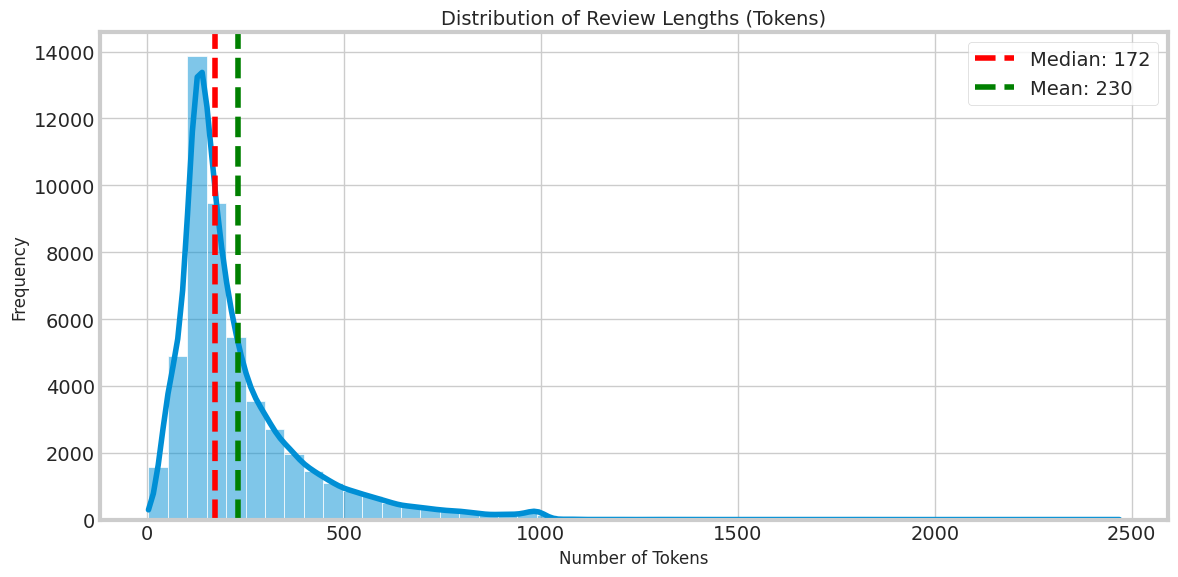


Number of extremely short reviews (<10 tokens): 5
Sample of short reviews:
  Original: More suspenseful, more subtle, much, much more disturbing.......
  Encoded: [51, 2419, 51, 1255, 72, 72, 51, 1216]
  Length: 8 tokens
----------------------------------------
  Original: Read the book, forget the movie!...
  Encoded: [326, 1, 277, 819, 1, 17]
  Length: 6 tokens
----------------------------------------
  Original: Primary plot!Primary direction!Poor interpretation....
  Encoded: [4075, 139486, 139487, 2903]
  Length: 4 tokens
----------------------------------------


In [92]:
# Visualize the distribution of encoded review lengths
plt.figure(figsize=(12, 6))
sns.histplot(review_lengths, bins=50, kde=True)
plt.title('Distribution of Review Lengths (Tokens)', fontsize=14)
plt.xlabel('Number of Tokens', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.axvline(x=np.median(review_lengths), color='red', linestyle='--',
            label=f'Median: {np.median(review_lengths):.0f}')
plt.axvline(x=np.mean(review_lengths), color='green', linestyle='--',
            label=f'Mean: {np.mean(review_lengths):.0f}')
plt.legend()
plt.tight_layout()
plt.show()

# Check for extremely short reviews (potential outliers)
short_reviews = [i for i, length in enumerate(review_lengths) if length < 10]
print(f"\nNumber of extremely short reviews (<10 tokens): {len(short_reviews)}")

if short_reviews:
    print("Sample of short reviews:")
    for idx in short_reviews[:3]:
        print(f"  Original: {df['review'].iloc[idx][:100]}...")
        print(f"  Encoded: {reviews_encoded[idx]}")
        print(f"  Length: {len(reviews_encoded[idx])} tokens")
        print("-" * 40)

# 5. Dataset Preparation

### 5.1 Padding

In [93]:
# Define a function to standardize sequence lengths through padding and truncation
def pad_features(reviews_int, seq_length):
    """
    Return features of review_ints, where each review is padded with zeros or
    truncated to the input seq_length.

    Parameters:
    -----------
    reviews_int : List[List[int]]
        List of reviews where each review is a list of integer word indices
    seq_length : int
        Fixed sequence length for all reviews

    Returns:
    --------
    features : np.ndarray
        Array of padded/truncated integer sequences with shape (len(reviews_int), seq_length)
    """
    # Initialize an array of zeros with shape (n_reviews, seq_length)
    features = np.zeros((len(reviews_int), seq_length), dtype=int)

    # Iterate through reviews
    for i, review in enumerate(reviews_int):
        review_len = len(review)

        # Handle short sequences: add padding zeros at the beginning
        if review_len <= seq_length:
            zeros = list(np.zeros(seq_length - review_len, dtype=int))
            # Place zeros at the beginning for more effective learning
            # (RNNs prioritize later sequence elements)
            new_sequence = zeros + review

        # Handle long sequences: truncate to seq_length
        else:
            # Preserve the most recent part of the review (recency effect)
            new_sequence = review[-seq_length:]

        # Store the padded/truncated sequence
        features[i, :] = np.array(new_sequence)

    return features

# Determine optimal sequence length
# Common approach: Choose a value that preserves most reviews while limiting excessive padding
seq_length = 200  # This captures a significant portion of the reviews

print(f"Standardizing sequences to length: {seq_length}")
# Apply padding/truncation
padded_features = pad_features(reviews_encoded, seq_length)

# Display statistics on standardized sequences
print(f"\nStandardized sequence shape: {padded_features.shape}")
print(f"  Number of sequences: {padded_features.shape[0]}")
print(f"  Sequence length: {padded_features.shape[1]} tokens")

# Verify pad_features implementation with examples
print("\nExample of standardized sequences:")
print("Short review (padded):")
short_idx = np.argmin([len(r) for r in reviews_encoded])
print(f"  Original length: {len(reviews_encoded[short_idx])} tokens")
print(f"  Padded sequence: {padded_features[short_idx, :20]} ... (zeros are padding)")

print("\nLong review (truncated):")
long_idx = np.argmax([len(r) for r in reviews_encoded])
print(f"  Original length: {len(reviews_encoded[long_idx])} tokens")
print(f"  Truncated sequence: {padded_features[long_idx, :20]} ...")

Standardizing sequences to length: 200

Standardized sequence shape: (50000, 200)
  Number of sequences: 50000
  Sequence length: 200 tokens

Example of standardized sequences:
Short review (padded):
  Original length: 4 tokens
  Padded sequence: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] ... (zeros are padding)

Long review (truncated):
  Original length: 2469 tokens
  Truncated sequence: [ 356  131  814  183   24 5248   56 2798  742    5 7918  802   18   27
   99 4215   45    1  802  183] ...


In [94]:
padded_features.shape

(50000, 200)

### 6.2 Dataset Partitioning

In [95]:
total_samples = len(padded_features)
train_ratio = 0.8
val_ratio = 0.1
test_ratio = 0.1

In [96]:
train_end = int(train_ratio * total_samples)
val_end = train_end + int(val_ratio * total_samples)

X_train = padded_features[:train_end]
X_val = padded_features[train_end:val_end]
X_test = padded_features[val_end:]

y_train = encoded_labels[:train_end]
y_val = encoded_labels[train_end:val_end]
y_test = encoded_labels[val_end:]

In [97]:
print("\nDataset Partitioning Results:")
print(f"  Total samples: {total_samples}")
print(f"  Training set: {len(X_train)} samples ({len(X_train)/total_samples*100:.1f}%)")
print(f"  Validation set: {len(X_val)} samples ({len(X_val)/total_samples*100:.1f}%)")
print(f"  Test set: {len(X_test)} samples ({len(X_test)/total_samples*100:.1f}%)")

# Verify class distribution across splits
print("\nClass Distribution Across Splits:")
print(f"  Full dataset: {np.mean(encoded_labels)*100:.1f}% positive")
print(f"  Training set: {np.mean(y_train)*100:.1f}% positive")
print(f"  Validation set: {np.mean(y_val)*100:.1f}% positive")
print(f"  Test set: {np.mean(y_test)*100:.1f}% positive")


Dataset Partitioning Results:
  Total samples: 50000
  Training set: 40000 samples (80.0%)
  Validation set: 5000 samples (10.0%)
  Test set: 5000 samples (10.0%)

Class Distribution Across Splits:
  Full dataset: 50.0% positive
  Training set: 50.0% positive
  Validation set: 50.7% positive
  Test set: 49.4% positive


### 6.3 Dataloader

In [98]:
train_data = TensorDataset(torch.from_numpy(X_train), torch.from_numpy(y_train))
val_data = TensorDataset(torch.from_numpy(X_val), torch.from_numpy(y_val))
test_data = TensorDataset(torch.from_numpy(X_test), torch.from_numpy(y_test))

In [99]:
batch_size = 50
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

In [100]:
print("\nDataLoader Configuration:")
print(f"  Batch size: {batch_size}")
print(f"  Training batches: {len(train_loader)}")
print(f"  Validation batches: {len(val_loader)}")
print(f"  Test batches: {len(test_loader)}")

# Display a sample batch
print("\nSample batch inspection:")
sample_x, sample_y = next(iter(train_loader))
print(f"  Input batch shape: {sample_x.shape}")  # [batch_size, sequence_length]
print(f"  Label batch shape: {sample_y.shape}")  # [batch_size]
print(f"  Sample input: {sample_x[0, :20]}")     # First 20 tokens of first sample
print(f"  Sample label: {sample_y[0].item()}")   # Label of first sample


DataLoader Configuration:
  Batch size: 50
  Training batches: 800
  Validation batches: 100
  Test batches: 100

Sample batch inspection:
  Input batch shape: torch.Size([50, 200])
  Label batch shape: torch.Size([50])
  Sample input: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
  Sample label: 0


# 7. Model Architectures

### 7.1 RNN Architecture

In [137]:
class SentimentRNN(nn.Module):
  def __init__(self, vocab_size, output_size, embedding_dim, hidden_dim, n_layers, drop_prob=0.5):
    super().__init__()
    self.output_size = output_size
    self.n_layers = n_layers
    self.hidden_dim = hidden_dim

    self.embedding = nn.Embedding(vocab_size, embedding_dim)
    self.rnn = nn.RNN(embedding_dim, hidden_dim, n_layers, batch_first=True, dropout=drop_prob)
    self.dropout = nn.Dropout(drop_prob)
    self.fc = nn.Linear(hidden_dim, output_size)
    self.sigmoid = nn.Sigmoid()

  def forward(self, x, hidden):
    """
        Forward pass through the network.

        Parameters:
        -----------
        x : torch.Tensor
            Input tensor of shape (batch_size, sequence_length)
        hidden : torch.Tensor
            Initial hidden state

        Returns:
        --------
        tuple(torch.Tensor, torch.Tensor)
            - Output tensor of shape (batch_size, output_size)
            -Final hidden state
        """
    batch_size = x.size(0)

    # Convert tokens to embeddings
    # Output shape: (batch_size, sequence_length, embedding_dim)
    embeds = self.embedding(x)

    # Process sequence through RNN
    # rnn_out shape: (batch_size, sequence_length, hidden_dim)
    # hidden shape: (n_layers, batch_size, hidden_dim)
    rnn_out, hidden = self.rnn(embeds, hidden)

    # Reshape RNN output to feed into fully-connected layer
    # This flattens the batch and sequence dimensions
    # New shape: (batch_size * sequence_length, hidden_dim)
    rnn_out = rnn_out.contiguous().view(-1, self.hidden_dim)

    # Apply dropout for regularization
    out = self.dropout(rnn_out)

    # Apply linear transformation
    # Output shape: (batch_size * sequence_length, output_size)
    out = self.fc(out)

    # Apply sigmoid activation for binary classification
    sig_out = self.sigmoid(out)

    # Reshape to separate batch and sequence dimensions
    # New shape: (batch_size, sequence_length, output_size)
    sig_out = sig_out.view(batch_size, -1)

    # Return only the output for the last time step
    # Final shape: (batch_size, output_size)
    return sig_out[:, -1], hidden

  def init_hidden(self, batch_size):
      """
      Initialize hidden state with zeros.

      Parameters:n
      -----------
      batch_size : int
          The batch size for the current forward pass

      Returns:
      --------
      torch.Tensor
          Hidden state tensor of shape (n_layers, batch_size, hidden_dim)
      """
      # Initialize weight tensor for proper device placement
      weight = next(self.parameters()).data

      # Check if GPU is available
      if torch.cuda.is_available():
          # Initialize hidden state on GPU
          hidden = weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().cuda()
      else:
          # Initialize hidden state on CPU
          hidden = weight.new(self.n_layers, batch_size, self.hidden_dim).zero_()

      return hidden

In [139]:
print("Initializing RNN model architecture...")

# Model hyperparameters
vocab_size = len(vocab_to_int) + 1  # +1 for padding token (0)
output_size = 1  # Binary classification
embedding_dim = 400  # Word embedding dimension
hidden_dim = 256  # Hidden state dimension
n_layers = 2  # Number of RNN layers

# Create model instance
rnn_model = SentimentRNN(vocab_size, output_size, embedding_dim, hidden_dim, n_layers)

# Display model architecture summary
print(rnn_model)
print(f"\nModel Parameters:")
total_params = sum(p.numel() for p in rnn_model.parameters())
trainable_params = sum(p.numel() for p in rnn_model.parameters() if p.requires_grad)
print(f"  Total parameters: {total_params:,}")
print(f"  Trainable parameters: {trainable_params:,}")

# Calculate approximate model size
model_size_mb = sum(p.numel() * p.element_size() for p in rnn_model.parameters()) / (1024 * 1024)
print(f"  Approximate model size: {model_size_mb:.2f} MB")

Initializing RNN model architecture...
SentimentRNN(
  (embedding): Embedding(181686, 400)
  (rnn): RNN(400, 256, num_layers=2, batch_first=True, dropout=0.5)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=256, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

Model Parameters:
  Total parameters: 72,974,689
  Trainable parameters: 72,974,689
  Approximate model size: 278.38 MB


### 7.1 LSTM Architecture

In [140]:
class SentimentLSTM(nn.Module):
    """
    Long Short-Term Memory Network for Sentiment Analysis.

    This model extends the basic RNN by using LSTM cells to better capture long-range dependencies
    in text sequences through specialized memory mechanisms.

    Architecture Parameters:
    - vocab_size: Size of the vocabulary (number of unique words)
    - output_size: Number of output classes (1 for binary classification)
    - embedding_dim: Dimensionality of word embeddings
    - hidden_dim: Number of hidden units in the LSTM layer
    - n_layers: Number of stacked LSTM layers
    - drop_prob: Dropout probability for regularization
    """

    def __init__(self, vocab_size, output_size, embedding_dim, hidden_dim, n_layers, drop_prob=0.5):
        """Initialize the model architecture and parameters."""
        super().__init__()

        # Save architecture parameters
        self.output_size = output_size
        self.n_layers = n_layers
        self.hidden_dim = hidden_dim

        # Embedding layer: Maps integer tokens to dense vectors
        # vocab_size + 1 to account for padding token (0)
        self.embedding = nn.Embedding(vocab_size, embedding_dim)

        # LSTM layer: Processes sequence data with memory cells
        # batch_first=True expects input shape: (batch_size, seq_len, features)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, n_layers,
                           dropout=drop_prob, batch_first=True)

        # Dropout layer: Reduces overfitting
        self.dropout = nn.Dropout(drop_prob)

        # Fully connected layer: Maps hidden state to classification output
        self.fc = nn.Linear(hidden_dim, output_size)

        # Sigmoid activation: Produces probability output for binary classification
        self.sigmoid = nn.Sigmoid()

    def forward(self, x, hidden):
        """
        Forward pass through the network.

        Parameters:
        -----------
        x : torch.Tensor
            Input tensor of shape (batch_size, sequence_length)
        hidden : tuple(torch.Tensor, torch.Tensor)
            Initial hidden state and cell state

        Returns:
        --------
        tuple(torch.Tensor, tuple(torch.Tensor, torch.Tensor))
            - Output tensor of shape (batch_size, output_size)
            - Tuple of final (hidden state, cell state)
        """
        # Get batch size from input
        batch_size = x.size(0)

        # Convert tokens to embeddings
        # Output shape: (batch_size, sequence_length, embedding_dim)
        embeds = self.embedding(x)

        # Process sequence through LSTM
        # lstm_out shape: (batch_size, sequence_length, hidden_dim)
        # hidden shape: (n_layers, batch_size, hidden_dim)
        # cell shape: (n_layers, batch_size, hidden_dim)
        lstm_out, hidden = self.lstm(embeds, hidden)

        # Reshape LSTM output to feed into fully-connected layer
        # Get the output for the last time step
        lstm_out = lstm_out[:, -1, :]

        # Apply dropout for regularization
        out = self.dropout(lstm_out)

        # Apply linear transformation
        # Output shape: (batch_size, output_size)
        out = self.fc(out)

        # Apply sigmoid activation for binary classification
        sig_out = self.sigmoid(out)

        return sig_out, hidden

    def init_hidden(self, batch_size):
        """
        Initialize hidden state and cell state with zeros.

        Parameters:
        -----------
        batch_size : int
            The batch size for the current forward pass

        Returns:
        --------
        tuple(torch.Tensor, torch.Tensor)
            Tuple containing:
            - Hidden state tensor of shape (n_layers, batch_size, hidden_dim)
            - Cell state tensor of shape (n_layers, batch_size, hidden_dim)
        """
        # Initialize weight tensor for proper device placement
        weight = next(self.parameters()).data

        # Check if GPU is available
        if torch.cuda.is_available():
            # Initialize hidden and cell states on GPU
            hidden = weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().cuda()
            cell = weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().cuda()
        else:
            # Initialize hidden and cell states on CPU
            hidden = weight.new(self.n_layers, batch_size, self.hidden_dim).zero_()
            cell = weight.new(self.n_layers, batch_size, self.hidden_dim).zero_()

        return (hidden, cell)

In [141]:
# Instantiate the LSTM model with the same hyperparameters as the RNN for fair comparison
print("Initializing LSTM model architecture...")

# Create model instance (using same hyperparameters as RNN)
lstm_model = SentimentLSTM(vocab_size, output_size, embedding_dim, hidden_dim, n_layers)

# Display model architecture summary
print(lstm_model)
print(f"\nModel Parameters:")
total_params = sum(p.numel() for p in lstm_model.parameters())
trainable_params = sum(p.numel() for p in lstm_model.parameters() if p.requires_grad)
print(f"  Total parameters: {total_params:,}")
print(f"  Trainable parameters: {trainable_params:,}")

# Calculate approximate model size
model_size_mb = sum(p.numel() * p.element_size() for p in lstm_model.parameters()) / (1024 * 1024)
print(f"  Approximate model size: {model_size_mb:.2f} MB")

# Compare parameters between RNN and LSTM
rnn_params = sum(p.numel() for p in rnn_model.parameters())
lstm_params = sum(p.numel() for p in lstm_model.parameters())
print(f"\nModel Comparison:")
print(f"  RNN parameters: {rnn_params:,}")
print(f"  LSTM parameters: {lstm_params:,}")
print(f"  LSTM has {lstm_params - rnn_params:,} more parameters than RNN")

Initializing LSTM model architecture...
SentimentLSTM(
  (embedding): Embedding(181686, 400)
  (lstm): LSTM(400, 256, num_layers=2, batch_first=True, dropout=0.5)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=256, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

Model Parameters:
  Total parameters: 73,874,785
  Trainable parameters: 73,874,785
  Approximate model size: 281.81 MB

Model Comparison:
  RNN parameters: 72,974,689
  LSTM parameters: 73,874,785
  LSTM has 900,096 more parameters than RNN


# 8. Training Configuration

In [142]:
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
if torch.cuda.is_available():
  torch.cuda.manual_seed(seed)
  torch.backends.cudnn.deterministic = True

In [143]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device = {device}")

Device = cuda


In [144]:
rnn_model = rnn_model.to(device)
lstm_model = lstm_model.to(device)

In [145]:
batch_size = 50
learning_rate = 0.001
epochs = 5
clip = 5  # Gradient clipping value
print_every = 100  # Print statistics every n mini-batches

In [146]:
# Loss function
criterion = nn.BCELoss()

# Optimizers - one for each model
rnn_optimizer = torch.optim.Adam(rnn_model.parameters(), lr=learning_rate)
lstm_optimizer = torch.optim.Adam(lstm_model.parameters(), lr=learning_rate)

# Learning rate schedulers
rnn_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    rnn_optimizer, mode='min', factor=0.5, patience=1)
lstm_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    lstm_optimizer, mode='min', factor=0.5, patience=1)

# Early stopping parameters
patience = 3  # Number of epochs to wait for improvement
min_delta = 0.001  # Minimum change to count as improvement

# Training monitoring variables
train_loss_history = {'rnn': [], 'lstm': []}
val_loss_history = {'rnn': [], 'lstm': []}
val_accuracy_history = {'rnn': [], 'lstm': []}
best_val_loss = {'rnn': float('inf'), 'lstm': float('inf')}
patience_counter = {'rnn': 0, 'lstm': 0}

In [147]:
# Display configuration summary
print("--- Training Configuration ---")
print(f"Batch Size: {batch_size}")
print(f"Learning Rate: {learning_rate}")
print(f"Epochs: {epochs}")
print(f"Gradient Clipping: {clip}")
print(f"Loss Function: {criterion.__class__.__name__}")
print(f"Optimizer: Adam")
print(f"Early Stopping Patience: {patience}")
print(f"Learning Rate Scheduler: ReduceLROnPlateau")

--- Training Configuration ---
Batch Size: 50
Learning Rate: 0.001
Epochs: 5
Gradient Clipping: 5
Loss Function: BCELoss
Optimizer: Adam
Early Stopping Patience: 3
Learning Rate Scheduler: ReduceLROnPlateau


In [148]:
# Create directory for saving models if it doesn't exist
import os
if not os.path.exists('models'):
    os.makedirs('models')
    print("Created directory 'models/' for saving trained models")

# 8. Training and Evaluation

In [149]:
def calculate_metrics(y_pred, y_true, threshold=0.5):
  """
  Calculate classification metrics from model predictions.

  Parameters:
  -----------
  y_pred : torch.Tensor or numpy.ndarray
      Predicted probabilities
  y_true : torch.Tensor or numpy.ndarray
      Ground truth labels
  threshold : float, default=0.5
      Threshold for binary classification

  Returns:
  --------
  dict
      Dictionary containing accuracy, precision, recall, and F1-score
  """
  # Convert tensors to numpy if needed
  if isinstance(y_pred, torch.Tensor):
      y_pred = y_pred.cpu().detach().numpy()
  if isinstance(y_true, torch.Tensor):
      y_true = y_true.cpu().detach().numpy()

  # Convert probabilities to binary predictions using threshold
  y_pred_binary = (y_pred > threshold).astype(int)

  # Calculate metrics
  accuracy = np.mean(y_pred_binary == y_true)

  # Prevent division by zero
  tp = np.sum((y_pred_binary == 1) & (y_true == 1))
  fp = np.sum((y_pred_binary == 1) & (y_true == 0))
  fn = np.sum((y_pred_binary == 0) & (y_true == 1))

  # Calculate precision, recall, and F1-score
  precision = tp / (tp + fp) if (tp + fp) > 0 else 0
  recall = tp / (tp + fn) if (tp + fn) > 0 else 0
  f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0

  return {
      'accuracy': accuracy,
      'precision': precision,
      'recall': recall,
      'f1_score': f1
  }

In [150]:
def train(model, train_loader, optimizer, criterion, clip, device, model_type):
  """
  Train model for one epoch.

  Parameters:
  -----------
  model : torch.nn.Module
      The neural network model
  train_loader : torch.utils.data.DataLoader
      DataLoader for training data
  optimizer : torch.optim.Optimizer
      Optimizer for updating model parameters
  criterion : torch.nn.Module
      Loss function
  clip : float
      Gradient clipping value
  device : torch.device
      Device to run training on (CPU or GPU)
  model_type : str
      Type of model ('rnn' or 'lstm') for tracking purposes

  Returns:
  --------
  float
      Average training loss for the epoch
  """
  model.train()

  total_loss = 0
  batch_count = 0

  for inputs, labels in train_loader:
    inputs,labels = inputs.to(device),labels.to(device)
    batch_count +=1

    h = model.init_hidden(batch_size)

    optimizer.zero_grad()

    if device == torch.device("cuda"):
      if model_type == 'rnn':
          h = h.detach()
      else:  # LSTM has tuple of (hidden, cell)
          h = tuple([each.detach() for each in h])

    output,h = model(inputs,h)
    loss = criterion(output.squeeze(),labels.float())
    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(),clip)
    optimizer.step()

    total_loss += loss.item()
    if batch_count % print_every == 0:
      print(f"  Batch {batch_count}/{len(train_loader)} | Loss: {loss.item():.4f}")

  return total_loss/len(train_loader)

In [151]:
def validate(model, val_loader, criterion, device, model_type):
  """
  Validate model on validation set.

  Parameters:
  -----------
  model : torch.nn.Module
      The neural network model
  val_loader : torch.utils.data.DataLoader
      DataLoader for validation data
  criterion : torch.nn.Module
      Loss function
  device : torch.device
      Device to run validation on (CPU or GPU)
  model_type : str
      Type of model ('rnn' or 'lstm') for tracking purposes

  Returns:
  --------
  tuple(float, dict)
      Average validation loss and performance metrics
  """
  model.eval()

  val_loss = 0

  all_preds = []
  all_labels = []

  with torch.no_grad():
      for inputs, labels in val_loader:
          inputs, labels = inputs.to(device), labels.to(device)

          h = model.init_hidden(batch_size)

          output, h = model(inputs, h)

          val_loss += criterion(output.squeeze(), labels.float()).item()

          all_preds.extend(output.squeeze().cpu().numpy())
          all_labels.extend(labels.cpu().numpy())

  val_loss = val_loss / len(val_loader)
  metrics = calculate_metrics(np.array(all_preds), np.array(all_labels))

  return val_loss, metrics

In [152]:
def test_model(model, test_loader, criterion, device, model_type):
    """
    Test model on the test set.

    Parameters:
    -----------
    model : torch.nn.Module
        The neural network model
    test_loader : torch.utils.data.DataLoader
        DataLoader for test data
    criterion : torch.nn.Module
        Loss function
    device : torch.device
        Device to run testing on (CPU or GPU)
    model_type : str
        Type of model ('rnn' or 'lstm') for tracking purposes

    Returns:
    --------
    tuple(float, dict)
        Test loss and performance metrics
    """
    model.eval()

    test_loss = 0

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            h = model.init_hidden(batch_size)

            output, h = model(inputs, h)

            test_loss += criterion(output.squeeze(), labels.float()).item()

            all_preds.extend(output.squeeze().cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    test_loss = test_loss / len(test_loader)
    metrics = calculate_metrics(np.array(all_preds), np.array(all_labels))

    return test_loss, metrics

### 8.3 Model Training

In [153]:
def train_model(model, train_loader, val_loader, optimizer, criterion, scheduler,
             clip, epochs, device, model_type):
    """
    Train a model with validation and early stopping.

    Parameters:
    -----------
    model : torch.nn.Module
        The neural network model
    train_loader : torch.utils.data.DataLoader
        DataLoader for training data
    val_loader : torch.utils.data.DataLoader
        DataLoader for validation data
    optimizer : torch.optim.Optimizer
        Optimizer for updating model parameters
    criterion : torch.nn.Module
        Loss function
    scheduler : torch.optim.lr_scheduler
        Learning rate scheduler
    clip : float
        Gradient clipping value
    epochs : int
        Number of epochs to train
    device : torch.device
        Device to run training on (CPU or GPU)
    model_type : str
        Type of model ('rnn' or 'lstm')

    Returns:
    --------
    dict
        Dictionary containing training history
    """
    # Initialize tracking variables
    train_losses = []
    val_losses = []
    val_metrics = []
    best_val_loss = float('inf')
    patience_counter = 0

    # Start time for monitoring total training time
    start_time = time.time()

    print(f"\n=== Training {model_type.upper()} Model ===")

    # Loop through epochs
    for epoch in range(1, epochs + 1):
        # Start time for current epoch
        epoch_start = time.time()

        # Train for one epoch
        train_loss = train(model, train_loader, optimizer, criterion, clip, device, model_type)
        train_losses.append(train_loss)

        # Validate
        val_loss, metrics = validate(model, val_loader, criterion, device, model_type)
        val_losses.append(val_loss)
        val_metrics.append(metrics)

        # Update learning rate based on validation loss
        scheduler.step(val_loss)

        # Calculate epoch duration
        epoch_duration = time.time() - epoch_start

        # Print epoch statistics
        print(f"Epoch {epoch}/{epochs} | Time: {epoch_duration:.2f}s")
        print(f"  Train Loss: {train_loss:.4f}")
        print(f"  Val Loss: {val_loss:.4f} | Val Accuracy: {metrics['accuracy']:.4f}")
        print(f"  Val Precision: {metrics['precision']:.4f} | Val Recall: {metrics['recall']:.4f} | Val F1: {metrics['f1_score']:.4f}")

        # Check if current model is best so far
        if val_loss < best_val_loss - min_delta:
            print(f"  Validation loss improved from {best_val_loss:.4f} to {val_loss:.4f}")
            best_val_loss = val_loss
            patience_counter = 0

            # Save best model
            torch.save(model.state_dict(), f'models/{model_type}_best.pt')
            print(f"  Saved best model to models/{model_type}_best.pt")
        else:
            patience_counter += 1
            print(f"  Validation loss did not improve. Patience: {patience_counter}/{patience}")

            # Check early stopping condition
            if patience_counter >= patience:
                print(f"  Early stopping triggered after {epoch} epochs")
                break

    # Calculate total training time
    total_time = time.time() - start_time
    print(f"\nTraining completed in {total_time:.2f} seconds")

    # Return training history
    return {
        'train_losses': train_losses,
        'val_losses': val_losses,
        'val_metrics': val_metrics,
        'best_val_loss': best_val_loss,
        'training_time': total_time
    }

# Import additional libraries
import time

# Train RNN model
print("\n" + "="*50)
print("BEGINNING RNN TRAINING")
print("="*50)
rnn_history = train_model(
    model=rnn_model,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=rnn_optimizer,
    criterion=criterion,
    scheduler=rnn_scheduler,
    clip=clip,
    epochs=epochs,
    device=device,
    model_type='rnn'
)

# Train LSTM model
print("\n" + "="*50)
print("BEGINNING LSTM TRAINING")
print("="*50)
lstm_history = train_model(
    model=lstm_model,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=lstm_optimizer,
    criterion=criterion,
    scheduler=lstm_scheduler,
    clip=clip,
    epochs=epochs,
    device=device,
    model_type='lstm'
)


BEGINNING RNN TRAINING

=== Training RNN Model ===
  Batch 100/800 | Loss: 0.6887
  Batch 200/800 | Loss: 0.5500
  Batch 300/800 | Loss: 0.6716
  Batch 400/800 | Loss: 0.7080
  Batch 500/800 | Loss: 0.7124
  Batch 600/800 | Loss: 0.5986
  Batch 700/800 | Loss: 0.6795
  Batch 800/800 | Loss: 0.5854
Epoch 1/5 | Time: 32.09s
  Train Loss: 0.6486
  Val Loss: 0.5815 | Val Accuracy: 0.7030
  Val Precision: 0.7174 | Val Recall: 0.6843 | Val F1: 0.7004
  Validation loss improved from inf to 0.5815
  Saved best model to models/rnn_best.pt
  Batch 100/800 | Loss: 0.4904
  Batch 200/800 | Loss: 0.5020
  Batch 300/800 | Loss: 0.5231
  Batch 400/800 | Loss: 0.6536
  Batch 500/800 | Loss: 0.6548
  Batch 600/800 | Loss: 0.6011
  Batch 700/800 | Loss: 0.5409
  Batch 800/800 | Loss: 0.5991
Epoch 2/5 | Time: 30.58s
  Train Loss: 0.5816
  Val Loss: 0.5424 | Val Accuracy: 0.7096
  Val Precision: 0.6759 | Val Recall: 0.8218 | Val F1: 0.7417
  Validation loss improved from 0.5815 to 0.5424
  Saved best mod

### 8.4 Evaluation

In [154]:
# Load best models
rnn_model.load_state_dict(torch.load('models/rnn_best.pt'))
lstm_model.load_state_dict(torch.load('models/lstm_best.pt'))

# Evaluate on test set
print("\n--- Evaluating Models on Test Set ---")

# Test RNN model
print("\nRNN Model Performance:")
rnn_test_loss, rnn_metrics = test_model(rnn_model, test_loader, criterion, device, 'rnn')
print(f"Test Loss: {rnn_test_loss:.4f}")
print(f"Test Accuracy: {rnn_metrics['accuracy']:.4f}")
print(f"Test Precision: {rnn_metrics['precision']:.4f}")
print(f"Test Recall: {rnn_metrics['recall']:.4f}")
print(f"Test F1-Score: {rnn_metrics['f1_score']:.4f}")

# Test LSTM model
print("\nLSTM Model Performance:")
lstm_test_loss, lstm_metrics = test_model(lstm_model, test_loader, criterion, device, 'lstm')
print(f"Test Loss: {lstm_test_loss:.4f}")
print(f"Test Accuracy: {lstm_metrics['accuracy']:.4f}")
print(f"Test Precision: {lstm_metrics['precision']:.4f}")
print(f"Test Recall: {lstm_metrics['recall']:.4f}")
print(f"Test F1-Score: {lstm_metrics['f1_score']:.4f}")

# Compare model performances
print("\n--- Model Comparison ---")
print(f"{'Metric':<15} {'RNN':<15} {'LSTM':<15} {'Difference':<15}")
print("-" * 60)
print(f"{'Test Loss':<15} {rnn_test_loss:<15.4f} {lstm_test_loss:<15.4f} {lstm_test_loss - rnn_test_loss:<15.4f}")
print(f"{'Accuracy':<15} {rnn_metrics['accuracy']:<15.4f} {lstm_metrics['accuracy']:<15.4f} {lstm_metrics['accuracy'] - rnn_metrics['accuracy']:<15.4f}")
print(f"{'Precision':<15} {rnn_metrics['precision']:<15.4f} {lstm_metrics['precision']:<15.4f} {lstm_metrics['precision'] - rnn_metrics['precision']:<15.4f}")
print(f"{'Recall':<15} {rnn_metrics['recall']:<15.4f} {lstm_metrics['recall']:<15.4f} {lstm_metrics['recall'] - rnn_metrics['recall']:<15.4f}")
print(f"{'F1-Score':<15} {rnn_metrics['f1_score']:<15.4f} {lstm_metrics['f1_score']:<15.4f} {lstm_metrics['f1_score'] - rnn_metrics['f1_score']:<15.4f}")
print(f"{'Training Time':<15} {rnn_history['training_time']:<15.2f} {lstm_history['training_time']:<15.2f} {lstm_history['training_time'] - rnn_history['training_time']:<15.2f}")

# Calculate relative improvement percentage
if rnn_metrics['accuracy'] > 0:
    accuracy_improvement = ((lstm_metrics['accuracy'] - rnn_metrics['accuracy']) / rnn_metrics['accuracy']) * 100
    print(f"\nLSTM accuracy improvement over RNN: {accuracy_improvement:.2f}%")

# Calculate faster/slower training time percentage
if rnn_history['training_time'] > 0:
    time_difference = ((lstm_history['training_time'] - rnn_history['training_time']) / rnn_history['training_time']) * 100
    if time_difference > 0:
        print(f"LSTM training was {time_difference:.2f}% slower than RNN")
    else:
        print(f"LSTM training was {abs(time_difference):.2f}% faster than RNN")


--- Evaluating Models on Test Set ---

RNN Model Performance:
Test Loss: 0.5101
Test Accuracy: 0.7696
Test Precision: 0.7924
Test Recall: 0.7231
Test F1-Score: 0.7561

LSTM Model Performance:
Test Loss: 0.3389
Test Accuracy: 0.8768
Test Precision: 0.8793
Test Recall: 0.8700
Test F1-Score: 0.8746

--- Model Comparison ---
Metric          RNN             LSTM            Difference     
------------------------------------------------------------
Test Loss       0.5101          0.3389          -0.1712        
Accuracy        0.7696          0.8768          0.1072         
Precision       0.7924          0.8793          0.0869         
Recall          0.7231          0.8700          0.1470         
F1-Score        0.7561          0.8746          0.1185         
Training Time   167.77          268.43          100.67         

LSTM accuracy improvement over RNN: 13.93%
LSTM training was 60.00% slower than RNN


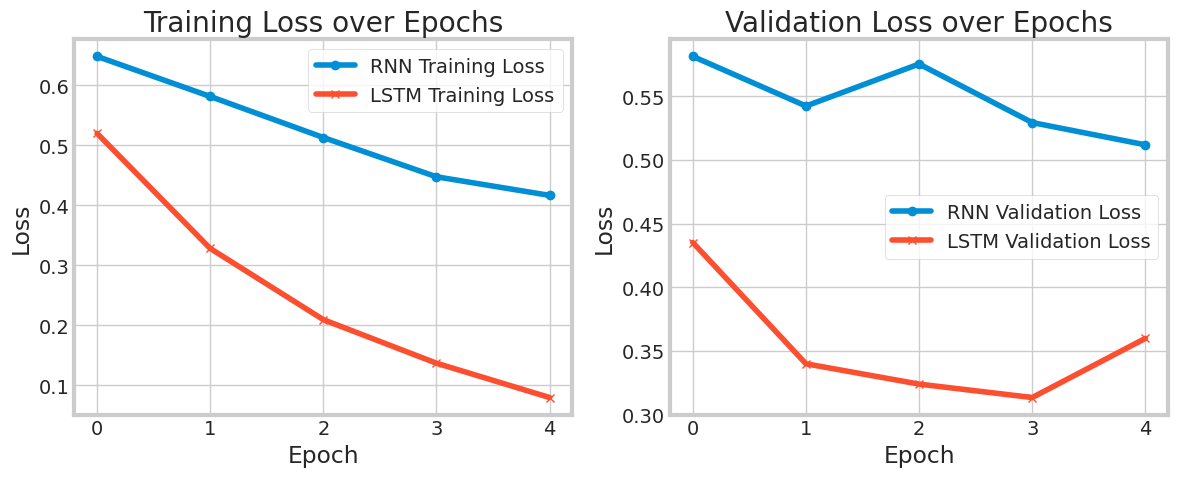

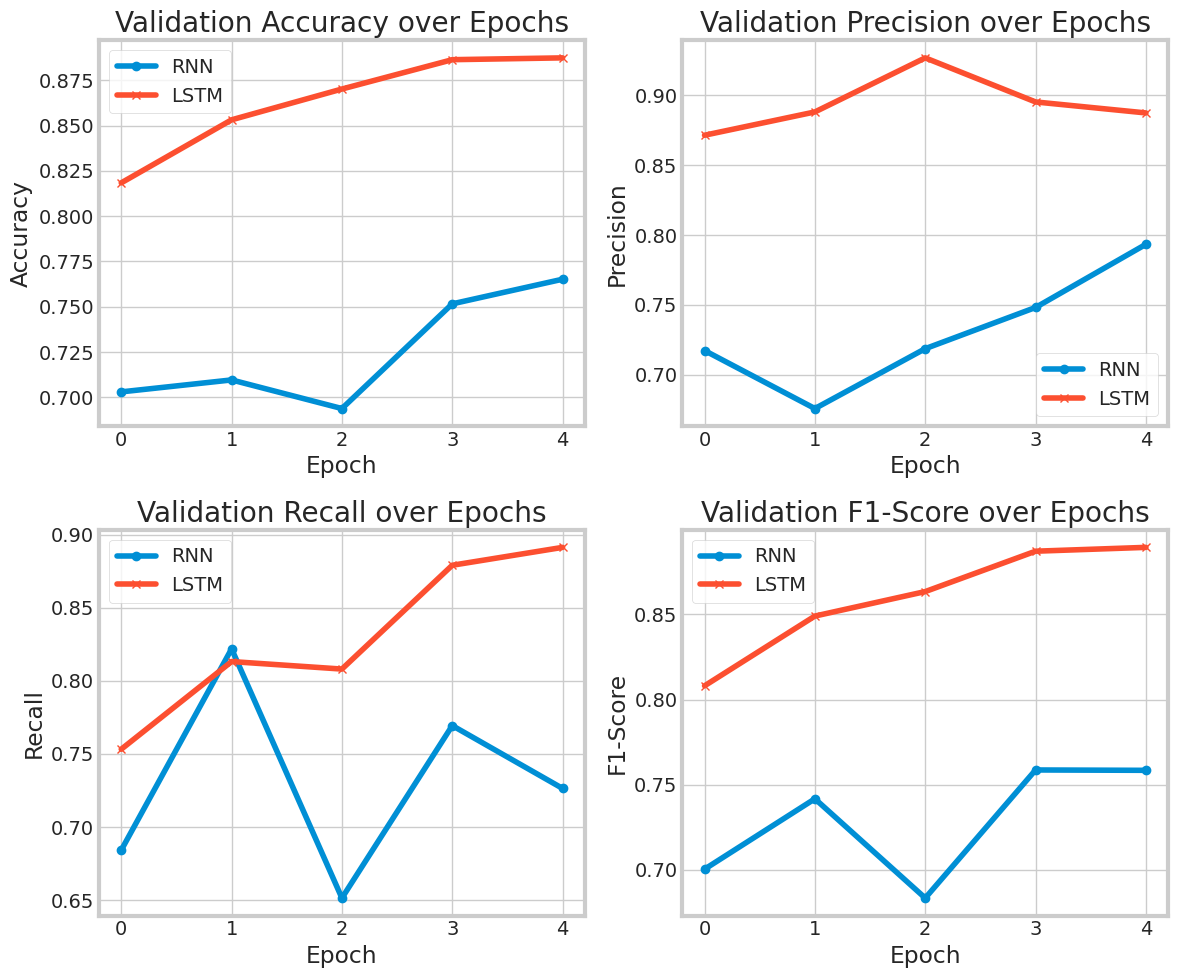

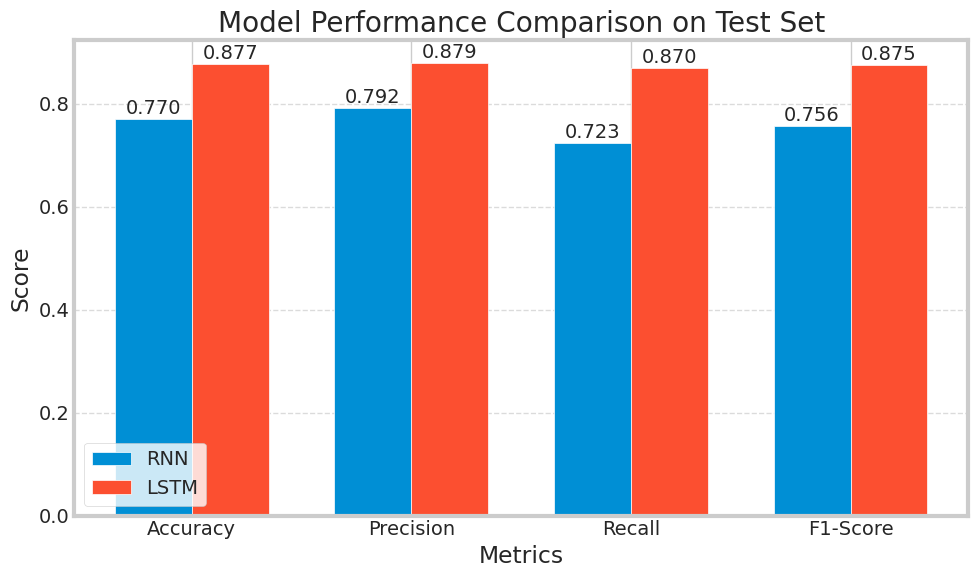

In [155]:
# Visualize training and validation loss
plt.figure(figsize=(12, 5))

# Plot training loss
plt.subplot(1, 2, 1)
plt.plot(rnn_history['train_losses'], label='RNN Training Loss', marker='o')
plt.plot(lstm_history['train_losses'], label='LSTM Training Loss', marker='x')
plt.title('Training Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Plot validation loss
plt.subplot(1, 2, 2)
plt.plot(rnn_history['val_losses'], label='RNN Validation Loss', marker='o')
plt.plot(lstm_history['val_losses'], label='LSTM Validation Loss', marker='x')
plt.title('Validation Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Extract validation accuracy from metrics
rnn_val_accuracy = [m['accuracy'] for m in rnn_history['val_metrics']]
lstm_val_accuracy = [m['accuracy'] for m in lstm_history['val_metrics']]

# Visualize validation metrics
plt.figure(figsize=(12, 10))

# Plot validation accuracy
plt.subplot(2, 2, 1)
plt.plot(rnn_val_accuracy, label='RNN', marker='o')
plt.plot(lstm_val_accuracy, label='LSTM', marker='x')
plt.title('Validation Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Plot validation precision
plt.subplot(2, 2, 2)
plt.plot([m['precision'] for m in rnn_history['val_metrics']], label='RNN', marker='o')
plt.plot([m['precision'] for m in lstm_history['val_metrics']], label='LSTM', marker='x')
plt.title('Validation Precision over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.legend()
plt.grid(True)

# Plot validation recall
plt.subplot(2, 2, 3)
plt.plot([m['recall'] for m in rnn_history['val_metrics']], label='RNN', marker='o')
plt.plot([m['recall'] for m in lstm_history['val_metrics']], label='LSTM', marker='x')
plt.title('Validation Recall over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Recall')
plt.legend()
plt.grid(True)

# Plot validation F1-score
plt.subplot(2, 2, 4)
plt.plot([m['f1_score'] for m in rnn_history['val_metrics']], label='RNN', marker='o')
plt.plot([m['f1_score'] for m in lstm_history['val_metrics']], label='LSTM', marker='x')
plt.title('Validation F1-Score over Epochs')
plt.xlabel('Epoch')
plt.ylabel('F1-Score')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Create a bar chart for test metrics comparison
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
rnn_values = [rnn_metrics['accuracy'], rnn_metrics['precision'],
              rnn_metrics['recall'], rnn_metrics['f1_score']]
lstm_values = [lstm_metrics['accuracy'], lstm_metrics['precision'],
               lstm_metrics['recall'], lstm_metrics['f1_score']]

plt.figure(figsize=(10, 6))
x = np.arange(len(metrics))
width = 0.35

plt.bar(x - width/2, rnn_values, width, label='RNN')
plt.bar(x + width/2, lstm_values, width, label='LSTM')

plt.xlabel('Metrics')
plt.ylabel('Score')
plt.title('Model Performance Comparison on Test Set')
plt.xticks(x, metrics)
plt.legend()
plt.grid(True, axis='y', linestyle='--', alpha=0.7)

# Add values on top of bars
for i, v in enumerate(rnn_values):
    plt.text(i - width/2, v + 0.01, f'{v:.3f}', ha='center')

for i, v in enumerate(lstm_values):
    plt.text(i + width/2, v + 0.01, f'{v:.3f}', ha='center')

plt.tight_layout()
plt.show()

# 10. Inference

In [156]:
def predict_sentiment(model, review_text, device, sequence_length=200):
    """
    Predict sentiment of a review text using a trained model.

    Parameters:
    -----------
    model : torch.nn.Module
        Trained sentiment analysis model
    review_text : str
        The text of the review to analyze
    device : torch.device
        Device to run inference on (CPU or GPU)
    sequence_length : int, default=200
        The fixed length to pad/truncate the input sequence

    Returns:
    --------
    tuple(str, float)
        Predicted sentiment label ('Positive' or 'Negative') and confidence score
    """
    # Set model to evaluation mode
    model.eval()

    # Preprocess the text (same as training data)
    review_text = review_text.lower()  # lowercase
    # review_text = re.sub(r'<.*?>', '', review_text)  # remove HTML tags
    # review_text = re.sub(r'[^a-zA-Z\s]', '', review_text)  # remove non-alphanumeric chars

    review_text = ''.join([c for c in review_text if c not in punctuation])
    # Tokenize the review
    words = review_text.split()


    # Convert words to indices using vocabulary
    word_indices = []
    for word in words:
        if word in vocab_to_int:
            word_indices.append(vocab_to_int[word])
        else:
            # Use a special token for unknown words
            word_indices.append(0)  # 0 is our padding token, also use for unknown

    # Pad or truncate sequence to fixed length
    if len(word_indices) > sequence_length:
        word_indices = word_indices[-sequence_length:]  # truncate
    else:
        zeros = [0] * (sequence_length - len(word_indices))
        word_indices = zeros + word_indices  # pad

    # Convert to tensor and add batch dimension
    inputs = torch.tensor(word_indices).unsqueeze(0).to(device)

    # Initialize hidden state
    h = model.init_hidden(1)
    if device == torch.device("cuda"):
        if isinstance(h, tuple):  # LSTM
            h = tuple([each.detach().cuda() for each in h])
        else:  # RNN
            h = h.detach().cuda()

    # Make prediction
    with torch.no_grad():
        output, _ = model(inputs, h)

    # Get prediction probability
    prob = output.item()

    # Determine sentiment label
    if prob >= 0.5:
        sentiment = 'Positive'
    else:
        sentiment = 'Negative'

    # Calculate confidence percentage
    confidence = prob if prob >= 0.5 else 1 - prob
    confidence_pct = confidence * 100

    return sentiment, confidence_pct


def analyze_review(review_text):
    """
    Analyze a review using both RNN and LSTM models for comparison.

    Parameters:
    -----------
    review_text : str
        The text of the review to analyze
    """
    print("\n" + "="*60)
    print(f"Analyzing review: {review_text[:100]}..." if len(review_text) > 100 else f"Analyzing review: {review_text}")
    print("="*60)

    # Make predictions with both models
    rnn_sentiment, rnn_confidence = predict_sentiment(rnn_model, review_text, device)
    lstm_sentiment, lstm_confidence = predict_sentiment(lstm_model, review_text, device)

    # Print results
    print("\nResults:")
    print(f"RNN Model: {rnn_sentiment} (Confidence: {rnn_confidence:.2f}%)")
    print(f"LSTM Model: {lstm_sentiment} (Confidence: {lstm_confidence:.2f}%)")

    # Check if models agree
    if rnn_sentiment == lstm_sentiment:
        print(f"\nBoth models agree: This review expresses {rnn_sentiment.lower()} sentiment.")
    else:
        print("\nModels disagree on sentiment classification.")
        print(f"RNN predicts {rnn_sentiment.lower()} with {rnn_confidence:.2f}% confidence.")
        print(f"LSTM predicts {lstm_sentiment.lower()} with {lstm_confidence:.2f}% confidence.")
        print("Consider the model with higher confidence or review the text further.")


# Test with a few example reviews
example_reviews = [
    "This movie was absolutely fantastic! The acting was superb and the plot kept me engaged from start to finish.",
    "I was very disappointed with this film. The characters were poorly developed and the story made no sense at all.",
    "It was an okay movie. Some parts were good but others were boring. Not great, not terrible.",
    "The special effects were amazing but everything else about this movie was terrible."
]

# Analyze each example review
for i, review in enumerate(example_reviews):
    print(f"\nExample {i+1}:")
    analyze_review(review)


# Interactive input for user reviews
print("\n" + "="*60)
print("Enter your own movie review to analyze (or type 'exit' to quit):")
print("="*60)

while True:
    user_input = input("\nEnter a movie review: ")
    if user_input.lower() == 'exit':
        print("Exiting sentiment analysis.")
        break
    if not user_input.strip():
        print("Please enter a review or type 'exit'.")
        continue

    analyze_review(user_input)


Example 1:

Analyzing review: This movie was absolutely fantastic! The acting was superb and the plot kept me engaged from start t...

Results:
RNN Model: Negative (Confidence: 93.96%)
LSTM Model: Positive (Confidence: 99.42%)

Models disagree on sentiment classification.
RNN predicts negative with 93.96% confidence.
LSTM predicts positive with 99.42% confidence.
Consider the model with higher confidence or review the text further.

Example 2:

Analyzing review: I was very disappointed with this film. The characters were poorly developed and the story made no s...

Results:
RNN Model: Negative (Confidence: 88.82%)
LSTM Model: Negative (Confidence: 99.85%)

Both models agree: This review expresses negative sentiment.

Example 3:

Analyzing review: It was an okay movie. Some parts were good but others were boring. Not great, not terrible.

Results:
RNN Model: Negative (Confidence: 96.06%)
LSTM Model: Negative (Confidence: 97.66%)

Both models agree: This review expresses negative sentim

KeyboardInterrupt: Interrupted by user